<a href="https://colab.research.google.com/github/jinfeijoy/NLP/blob/main/kaggle_IMDB_Review/notebook/IMDB_fastai1_with_transformer_googlecolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Please select GPU first (from Edit->NotebookSetting)
import pandas as pd
import numpy as np
import io
import os
import re
from google.colab import drive
!pip install fastai==1.0.58
# !pip install urllib3==1.25.4
!pip install transformers==2.5.1

drive.mount('/content/drive')
import transformers
import torch
import torch.optim as optim
import random 
from fastai import *
from fastai.text import *
from fastai.callbacks import *

     |████████████████████████████████| 245kB 7.3MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 501kB 7.4MB/s 
     |████████████████████████████████| 5.6MB 29.7MB/s 
     |████████████████████████████████| 901kB 47.6MB/s 
     |████████████████████████████████| 1.2MB 45.1MB/s 
     |████████████████████████████████| 133kB 56.3MB/s 
     |████████████████████████████████| 7.6MB 36.7MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
ERROR: botocore 1.20.89 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
Mounted at /content/drive


# Load Data
Reference: https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta

In [4]:
path = '/content/drive/MyDrive/colab_data'
def de_emojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
def tweet_proc(df, text_col='text'):
    df['orig_text'] = df[text_col]
    # Remove twitter handles
    df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',x))
    # Remove URLs
    df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", x))
    # Remove emojis
    df[text_col] = df[text_col].apply(de_emojify)
    # Remove hashtags
    df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',x))
    return df[df[text_col]!='']


In [49]:
basic_tweet.new_sentiment.value_counts()

neutral     12251
positive     9804
negative     8628
Name: new_sentiment, dtype: int64

In [50]:
basic_tweet = pd.read_csv(os.path.join(path, "tweet_dataset.csv"))
basic_tweet = covid_tweet[(covid_tweet.text.isnull()==False) & (covid_tweet.sentiment != 'empty')].drop_duplicates().reset_index(drop=True)
basic_tweet = tweet_proc(covid_tweet,'text').dropna(subset=['new_sentiment']).dropna(subset=['sentiment']).dropna(subset=['text'])
basic_tweet['label'] = np.where(basic_tweet.new_sentiment=='negative',-1,(np.where(basic_tweet.new_sentiment=='positive',1,0)))
print(len(basic_tweet))
basic_tweet.head(3)

30683


,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text,orig_text,label
0,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache,Layin n bed with a headache ughhhh...waitin o...,-1
1,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy,Funeral ceremony...gloomy friday...,-1
2,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!,wants to hang out with friends SOON!,1


# Main transformers classes
* A **model class** to load/store a particular pre-train model.
* A **tokenizer class** to pre-process the data and make it compatible with a particular model.
* A **configuration class** to load/store the configuration of a particular model.

Pre-trained model name can be found here: https://huggingface.co/transformers/pretrained_models.html#pretrained-models

In [51]:
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [11]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [12]:
seed = 42
use_fp16 = False
bs = 16

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

model_type = 'distilbert'
pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [13]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [14]:
# Function to set the seed for generating random numbers
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [15]:
seed_all(seed)

# Data Pre-processing

### Custom Tokenizer

In [16]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        # self.max_seq_len = int(np.percentile(pretrained_tokenizer.max_len, 95))
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [52]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be carefull about 3 things :

1. As we are not using RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with `add_prefix_space` set to `True`.

Below, you can find the resume of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the HuggingFace documentation in each model section.

`bert:       [CLS] + tokens + [SEP] + padding`

`roberta:    [CLS] + prefix_space + tokens + [SEP] + padding`

`distilbert: [CLS] + tokens + [SEP] + padding`

`xlm:        [CLS] + tokens + [SEP] + padding`

`xlnet:      padding + tokens + [SEP] + [CLS]`

### Custom Numericalizer

In [18]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

### Custom processor

In [26]:
transformer_vocab = TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab = transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos = False, include_eos = False)
transformer_processor = [tokenize_processor, numericalize_processor]

## Setting up the Databunch

In [27]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [54]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(basic_tweet, test_size=0.3, random_state=42)

In [55]:
databunch = (TextList.from_df(train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Check batch and tokenizer 

In [ ]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"[CLS] within the realm of science fiction , two particular themes consistently eli ##cit interest , were initially explored in the literature of a pre - cinematic era , and have since been periodically revisited by filmmakers and writers alike , with varying degrees of success . the first theme , that of time travel , has held an un ##wave ##ring fascination for fans of film , as well",negative
"[CLS] despite its many faults , hallmark ' s 1995 version of gu ##lli ##ver ' s travels is still the finest adaptation of jonathan swift ' s satirical classic - largely because it not only includes all of gu ##lli ##ver ' s many travels but also includes the satire that ' s often overlooked . unfortunately the twin problems of the book ' s highly ep ##iso ##dic",positive
"[CLS] i first saw this film by chance when i was visiting my uncle in arizona about 3 and 1 / 2 years ago . the vhs print was a little faded looking , but i was very haunted by what i had watched . did it all make sense ? well , honestly , no it didn ' t . however , this is a film that requires more",positive
"[CLS] as a big fan of brian yu ##z ##na and the majority of the movies he ' s been involved in , i guessed i ' d enjoy pro ##geny . i didn ' t , although in ways it has it ' s moments . however , if you ' re expecting something of the cal ##ib ##re of society or beyond re ##ani ##mat ##or , you",negative
"[CLS] this movie was awful , especially considering the work that must have gone into its production . though it ' s not as bad as ax ' em , it is quite awful . take into account the obvious rip - offs from glad ##ia ##tor and raiders of the lost ark , and what do you get ? this sm ##org ##as ##bor ##d of awful make -",negative


Check batch and numericalizer :

In [ ]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([16, 512])
tensor([[  101,  2123,  1005,  ...,  1012,  1999,   102],
        [  101,  1996, 10576,  ...,  1996,  3239,   102],
        [  101,  2045,  2031,  ..., 12436, 28168,   102],
        ...,
        [  101,  1008,  1008,  ...,  1997,  2014,   102],
        [  101,  1045,  2031,  ...,  1997,  2204,   102],
        [  101,  2048, 28466,  ..., 25764, 13954,   102]])


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Custom model

In [41]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [57]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = len(basic_tweet.label.unique())
print(len(basic_tweet.label.unique()))
config.use_bfloat16 = use_fp16
print(config)

3
DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "num_beams": 1,
  "num_labels": 3,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "qa_dropout": 0.1,
  "repetition_penalty": 1.0,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "temperature": 1.0,
  "tie_weights_": true,
  "top_k": 50,
  "top_p": 1.0,
  "torchscript": false,
 

In [43]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

## Learner : Custom Optimizer / Custom Metric

In [58]:
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])#.to_fp16()

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

if use_fp16: learner = learner.to_fp16()

In [ ]:
print(learner.model)

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

In [ ]:
# list_layers = [learner.model.transformer.roberta.embeddings,
#               learner.model.transformer.roberta.encoder.layer[0],
#               learner.model.transformer.roberta.encoder.layer[1],
#               learner.model.transformer.roberta.encoder.layer[2],
#               learner.model.transformer.roberta.encoder.layer[3],
#               learner.model.transformer.roberta.encoder.layer[4],
#               learner.model.transformer.roberta.encoder.layer[5],
#               learner.model.transformer.roberta.encoder.layer[6],
#               learner.model.transformer.roberta.encoder.layer[7],
#               learner.model.transformer.roberta.encoder.layer[8],
#               learner.model.transformer.roberta.encoder.layer[9],
#               learner.model.transformer.roberta.encoder.layer[10],
#               learner.model.transformer.roberta.encoder.layer[11],
#               learner.model.transformer.roberta.pooler]
# learner.split(list_layers)
learner.freeze_to(-1)
# learner.summary()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 1.45E-06


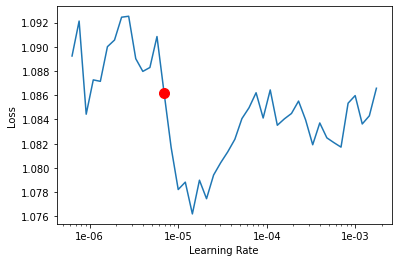

In [59]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.091724,1.092582,0.381928,0.618072,01:15
1,1.088575,1.092346,0.381928,0.618072,01:18
2,1.091031,1.092327,0.381928,0.618072,01:16


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


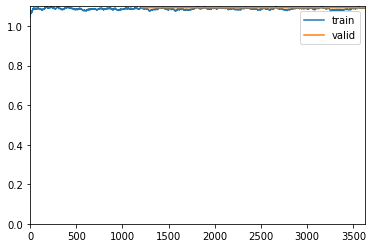

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [60]:
learner.unfreeze()
# learner.freeze_to(-2)
learner.fit_one_cycle(3,max_lr=1e-05)

In [48]:
learner.predict('I am so sad today')

(Category neutral,
 tensor(1),
 tensor([2.7656e-01, 4.1231e-01, 3.1112e-01, 2.7256e-07, 2.7866e-07, 2.1317e-07,
         2.5102e-07, 2.9112e-07, 1.8234e-07, 1.7835e-07, 3.4957e-07, 3.0324e-07]))

In [ ]:
learner.export(file = os.path.join(path, 'transformer.pkl'))

In [ ]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [ ]:
test_preds

array([[0.50234 , 0.497659],
       [0.50234 , 0.497659],
       [0.50234 , 0.497659],
       [0.50234 , 0.497659],
       ...,
       [0.50234 , 0.497659],
       [0.50234 , 0.497659],
       [0.50234 , 0.497659],
       [0.50234 , 0.497659]], dtype=float32)

In [ ]:
test['prediction'] = np.argmax(test_preds,axis=1)

In [ ]:
test.head(3)

In [ ]:
np.argmax(test_preds,axis=1)